# Ex6

In [6]:
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from torch import nn
import torch.nn.functional as F
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
import Fast_MRI_dataloader 
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 1
# Load train and test
# train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)
import warnings
warnings.filterwarnings("ignore") # Turn off warnings

PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print(PATH)

train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(PATH, batch_size)

Folders in the Fast_MRI_Knee: ['MNIST', 'Model', 'test', 'train']
d:\gittutorial-TootJack\5LSL0_MSPD\project4\Code - for students\Fast_MRI_Knee


In [7]:
# Define a FCN 
class FCN(nn.Module):                 
    """basic block: (convolution => [BN] => ReLU)"""

    def __init__(self, n_channels=1):
        super().__init__()
        self.FCN = nn.Sequential(
            nn.Conv2d(n_channels, out_channels = 32, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Upsampling
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size=1) # output
        )

    def forward(self, x):
        return self.FCN(x)  

In [8]:
def get_partial_kspace(fks,M):
    return(torch.mul(fks,M))

def calculate_full_kspace(input):
    return(torch.fft.fftshift(torch.fft.fft2(input)))

def get_accelerated_measurement_image(pks):
    return(torch.fft.ifft2(torch.fft.ifftshift(pks)))

In [4]:
# for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
#     y_img = get_accelerated_measurement_image(torch.abs(kspace))
#     y_img_rec = torch.fft.ifft2(torch.abs(kspace))
#     continue


100%|██████████| 245/245 [00:03<00:00, 68.73it/s]


Text(0.5, 1.0, 'partial k-space')

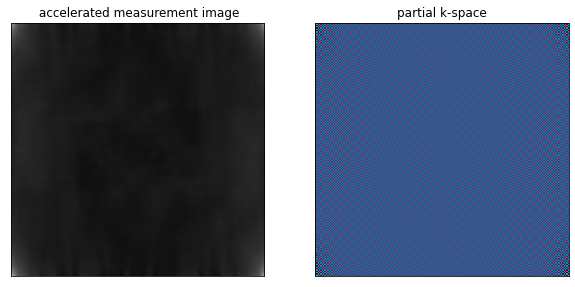

In [5]:
# plt.figure(figsize = (10,10))

# plt.subplot(1,2,1)
# plt.imshow(torch.real(y_img[0,:,:]),cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title(' accelerated measurement image')

# plt.subplot(1,2,2)
# plt.imshow(torch.real(y_img_rec[0,:,:]),vmin=-2.3,interpolation='nearest')
# plt.xticks([])
# plt.yticks([])
# plt.title('partial k-space')

In [16]:
class ProxNet_(nn.Module):
    def __init__(self, mu = 0.01):
        super(ProxNet_,self).__init__()
        """ 1 FCN layer """
        self.mu = mu
        self.CNN1 = FCN()
        self.CNN2 = FCN()
        self.CNN3 = FCN()
        self.CNN4 = FCN()
        self.CNN5 = FCN()

    def forward(self,y, M):
        y_img = get_accelerated_measurement_image(torch.abs(y))          # get recovered image
        x_recon = torch.abs(self.CNN1(torch.real(y_img)))                   # get output image

        tr_Fullk = calculate_full_kspace(torch.abs(x_recon)) # image to full k-space
        x_k = torch.multiply((1-self.mu),torch.mul(tr_Fullk, M)) + torch.multiply(self.mu,y) # partial k-space
        x_k_new = torch.abs(get_accelerated_measurement_image(x_k)) # To image space
        x_recon = torch.abs(self.CNN2(x_k_new)) # get output image

        tr_Fullk = calculate_full_kspace(torch.abs(x_recon)) # image to full k-space
        x_k = torch.multiply((1-self.mu),torch.mul(tr_Fullk, M)) + torch.multiply(self.mu,y) # partial k-space
        x_k_new = torch.abs(get_accelerated_measurement_image(x_k)) # To image
        x_recon = torch.abs(self.CNN3(x_k_new))

        tr_Fullk = calculate_full_kspace(torch.abs(x_recon)) # image to full k-space
        x_k = torch.multiply((1-self.mu),torch.mul(tr_Fullk, M)) + torch.multiply(self.mu,y) # partial k-space
        x_k_new = torch.abs(get_accelerated_measurement_image(x_k)) # To image
        x_recon = torch.abs(self.CNN4(x_k_new))

        tr_Fullk = calculate_full_kspace(torch.abs(x_recon)) # image to full k-space
        x_k = torch.multiply((1-self.mu),torch.mul(tr_Fullk, M)) + torch.multiply(self.mu,y) # partial k-space
        x_k_new = torch.abs(get_accelerated_measurement_image(x_k)) # To image
        x_recon = torch.abs(self.CNN5(x_k_new))
  
        return x_recon


In [17]:
no_epochs = 10
learning_rate = 3e-4

# create the autoencoder
model = ProxNet_()
model.cuda() # Transfer to GPU

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
critereon = nn.MSELoss()

# %% training loop
# go over all epochs
loss_list_train = []
loss_list_test = []
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch+1}:")
    loss_sum_train = 0
    loss_sum_test = 0
    # go over all minibatches
    for i,(kspace, M, gt) in enumerate(tqdm(train_loader)):
        gt = gt.cuda()
        kspace = kspace.unsqueeze(1).cuda()
        M = M.cuda()

        model.train()
        optimizer.zero_grad()

        # Run the forward pass
        x_recon = model(torch.real(kspace), M)
        loss = critereon(x_recon, gt)

        # Backprop
        loss.backward()

        # Perform the Adam optimizer
        optimizer.step()
        loss_sum_train += loss.data
    loss_list_train .append(loss_sum_train/len(train_loader.dataset))
    for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
        gt = gt.cuda()
        kspace = kspace.unsqueeze(1).cuda()
        M = M.cuda()

        model.eval()
        optimizer.zero_grad()

        # Run the forward pass
        x_recon = model(torch.real(kspace), M)
        loss = critereon(x_recon, gt)
        loss_sum_test += loss.data
    loss_list_test .append(loss_sum_test/len(train_loader.dataset))
# save the trained model
torch.save(model.state_dict(), PATH+'/Model/state_ProxNet.pt')



Training Epoch 1:


100%|██████████| 245/245 [00:04<00:00, 49.10it/s]



Training Epoch 2:


100%|██████████| 245/245 [00:07<00:00, 33.58it/s]



Training Epoch 3:


100%|██████████| 245/245 [00:07<00:00, 33.49it/s]



Training Epoch 4:


100%|██████████| 245/245 [00:07<00:00, 33.61it/s]



Training Epoch 5:


100%|██████████| 245/245 [00:07<00:00, 33.26it/s]



Training Epoch 6:


100%|██████████| 245/245 [00:06<00:00, 36.29it/s]



Training Epoch 7:


100%|██████████| 245/245 [00:07<00:00, 33.92it/s]



Training Epoch 8:


100%|██████████| 245/245 [00:07<00:00, 30.83it/s]



Training Epoch 9:


100%|██████████| 245/245 [00:07<00:00, 33.62it/s]



Training Epoch 10:


100%|██████████| 245/245 [00:07<00:00, 33.84it/s]


In [18]:
loss_list_trai = []
loss_list_tes = []
for j,k in zip(loss_list_train,loss_list_test):
    loss_list_trai.append(j.cpu().detach().numpy())
    loss_list_tes.append(k.cpu().detach().numpy())
print(loss_list_tes[-1])

0.077865504


In [19]:
from bokeh.models import LinearAxis
from bokeh.plotting import figure
from bokeh.io import show
p = figure(x_axis_label='Number of epochs',y_axis_label='Train Loss', width=850,x_range = (0,no_epochs), title='Train loss')
p.add_layout(LinearAxis(axis_label='Test Loss'), 'right')
p.line(np.arange(len(loss_list_trai)), loss_list_trai, legend_label="Train Loss")
p.line(np.arange(len(loss_list_tes)), loss_list_tes, legend_label="Test Loss", color='red')
show(p)

In [10]:
def get_partial_kspace(fks,M):
    return(torch.mul(fks,M))

def calculate_full_kspace(input):
    return(torch.fft.fftshift(torch.fft.fft2(input)))

def get_accelerated_measurement_image(pks):
    return(torch.fft.ifft2(torch.fft.ifftshift(pks)))

In [20]:
CNN = ProxNet_()
CNN.load_state_dict(torch.load(PATH+'/Model/state_ProxNet.pt'))
CNN.eval()
CNN.cpu()
re_img = []
ipk = []
gtl = []
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    kspace = kspace.unsqueeze(1)
    fkspace = calculate_full_kspace(gt)
    pks = get_partial_kspace(fkspace,M)
    ipk.append(torch.real(get_accelerated_measurement_image(pks).squeeze(0)))
    re_img.append(CNN(torch.real(kspace), M).detach().numpy())
    gtl.append(gt.squeeze(0))
    continue

100%|██████████| 245/245 [01:11<00:00,  3.41it/s]


In [12]:
print(len(re_img))


245


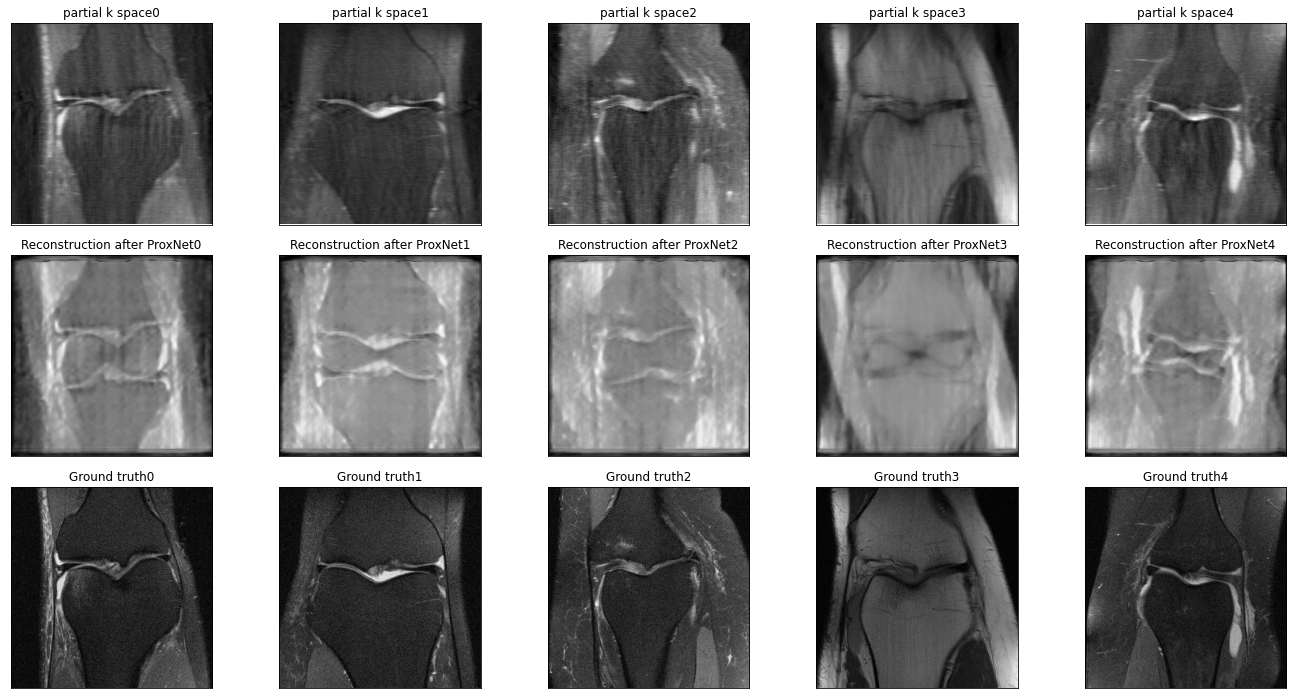

In [21]:
# x_hat = {}
# for i in range(5):
#     x_hat[i] = CNN(torch.real(kspace[i]), M[i]).squeeze(0).squeeze(0).detach().numpy()

fig = plt.figure(figsize=(20,10))
for i in range(5):
    ax0 = fig.add_subplot(3, 5, i+1)
    ax0.imshow(ipk[i],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.title('partial k space'+str(i))

    ax1 = fig.add_subplot(3, 5, i+6)
    ax1.imshow(re_img[i].squeeze(0).squeeze(0),cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    plt.title('Reconstruction after ProxNet'+str(i))

    ax2 = fig.add_subplot(3, 5, i+11)
    ax2.imshow(gtl[i],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    plt.title('Ground truth'+str(i))